<a href="https://colab.research.google.com/github/Odaenethus/hello-github/blob/main/fine%20tuning%20vs%20frozen%20encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U transformers datasets accelerate scipy scikit-learn


In [ ]:
import torch, numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)


Using: cuda


In [ ]:
ds = load_dataset("jingjietan/essays-big5")
print(ds["train"].column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/795k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/953k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1578 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/395 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/494 [00:00<?, ? examples/s]

['O', 'C', 'E', 'A', 'N', 'ptype', 'text', '__index_level_0__']


In [ ]:
ds = load_dataset("jingjietan/essays-big5") # Reload the dataset to its original state
TRAITS = ["O","C","E","A","N"]

def format_example(x):
    return {
        "text": x["text"],
        "labels": [float(x[t]) for t in TRAITS]
    }

ds = ds.map(format_example, remove_columns=ds["train"].column_names)

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

In [ ]:
MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize(batch):
    out = tokenizer(batch["text"], padding="max_length",
                    truncation=True, max_length=256)
    out["labels"] = batch["labels"]
    return out

ds = ds.map(tokenize, batched=True, remove_columns=["text"])
ds.set_format("torch")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def compute_metrics(pred):
    y_pred = pred.predictions
    y_true = pred.label_ids

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred, multioutput="uniform_average")

    pearsons, spearmans = [], []
    for i in range(5):
        pearsons.append(pearsonr(y_true[:,i], y_pred[:,i])[0])
        spearmans.append(spearmanr(y_true[:,i], y_pred[:,i]).correlation)

    return {
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "pearson": np.mean(pearsons),
        "spearman": np.mean(spearmans),
    }


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class BigFiveRegressor(nn.Module):
    def __init__(self, freeze):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL)
        if freeze:
            for p in self.encoder.parameters():
                p.requires_grad = False
        self.head = nn.Linear(self.encoder.config.hidden_size, 5)
        self.loss = nn.MSELoss()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        x = self.encoder(input_ids=input_ids,
                         attention_mask=attention_mask).last_hidden_state[:,0]
        preds = self.head(x)
        loss = self.loss(preds, labels) if labels is not None else None
        return {"loss": loss, "logits": preds}


In [ ]:
from transformers import Trainer, TrainingArguments

def run(freeze, seed):
    torch.manual_seed(seed); np.random.seed(seed)

    model = BigFiveRegressor(freeze).to(DEVICE)

    args = TrainingArguments(
        output_dir="out",
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=5e-4 if freeze else 2e-5,
        per_device_train_batch_size=32 if freeze else 16,
        num_train_epochs=6 if freeze else 3,
        fp16=torch.cuda.is_available(),
        seed=seed,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds["train"],
        eval_dataset=ds["validation"],
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer.evaluate(ds["test"])


In [ ]:
results = []
for s in [42,43,44]:
    r1 = run(freeze=True, seed=s)
    r1["approach"] = "frozen"
    r2 = run(freeze=False, seed=s)
    r2["approach"] = "fine_tune"
    results += [r1, r2]

import pandas as pd
pd.DataFrame(results)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss


TypeError: got an unexpected keyword argument 'squared'

In [ ]:

!pip -q install captum safetensors


In [ ]:
!pip -q install -U scipy scikit-learn shap transformers safetensors


In [ ]:
!pip -q install -U transformers torch

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Important: output_attentions=True
model = AutoModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE)
model.eval()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 516.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSelfAttention(
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
text = "I enjoy meeting new people, talking in groups, and I feel energized after social events."

enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
input_ids = enc["input_ids"].to(DEVICE)
attention_mask = enc["attention_mask"].to(DEVICE)

with torch.no_grad():
    out = model(input_ids=input_ids, attention_mask=attention_mask)

attentions = out.attentions  # list: num_layers, each (batch, num_heads, seq, seq)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().tolist())

print("Num layers:", len(attentions))
print("Attention shape (layer0):", attentions[0].shape)
print("Tokens:", tokens[:30], "...")


Num layers: 6
Attention shape (layer0): torch.Size([1, 12, 23, 23])
Tokens: ['[CLS]', 'i', 'enjoy', 'meeting', 'new', 'people', ',', 'talking', 'in', 'groups', ',', 'and', 'i', 'feel', 'en', '##er', '##gi', '##zed', 'after', 'social', 'events', '.', '[SEP]'] ...


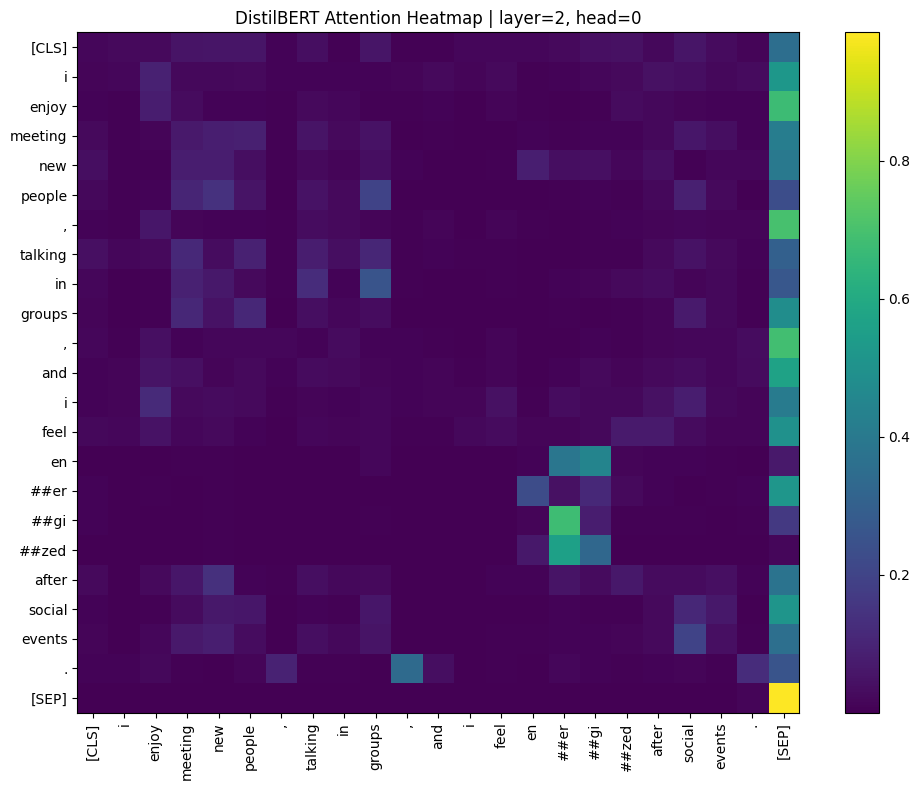

In [ ]:
layer = 2      # 0..5 for DistilBERT (6 layers)
head  = 0      # 0..11 heads

A = attentions[layer][0, head].detach().cpu().numpy()  # (seq, seq)

# Optional: trim to non-padding tokens
valid_len = int(attention_mask[0].sum().item())
A = A[:valid_len, :valid_len]
tok = tokens[:valid_len]

plt.figure(figsize=(10, 8))
plt.imshow(A, aspect="auto")
plt.xticks(range(len(tok)), tok, rotation=90)
plt.yticks(range(len(tok)), tok)
plt.title(f"DistilBERT Attention Heatmap | layer={layer}, head={head}")
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
# Even if it's not literally CLS, it's the first position representation.
query_pos = 0

row = A[query_pos]  # attention from token 0 to all tokens
topk = min(10, len(row))
top_idx = np.argsort(row)[::-1][:topk]

print("Token at query_pos:", tok[query_pos])
print("Top attended-to tokens:")
for i in top_idx:
    print(f"{i:2d}  {tok[i]:>12s}  attn={row[i]:.4f}")


Token at query_pos: [CLS]
Top attended-to tokens:
22         [SEP]  attn=0.3567
19        social  attn=0.0572
 9        groups  attn=0.0571
 5        people  attn=0.0553
 4           new  attn=0.0546
 3       meeting  attn=0.0536
17         ##zed  attn=0.0459
16          ##gi  attn=0.0409
 7       talking  attn=0.0360
20        events  attn=0.0275
